# **1-Dataset Analysis:**


## *i) Cleaning Dataset:* <br />
   Jan 23 Last edits

Latest check 30th of Jan. 2023 at 5:00PM

### **Importings:**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from ast import literal_eval




In [2]:
data= pd.read_csv("../data-history/up-to-date-MAL/anime_Feb23.csv")


print(data.shape)
data.head(5).T

(23936, 31)


,0,1,2,3,4
id,16498,1535,5114,30276,11757
title,Shingeki no Kyojin,Death Note,Fullmetal Alchemist: Brotherhood,One Punch Man,Sword Art Online
media_type,tv,tv,tv,tv,tv
mean,8.53,8.62,9.11,8.5,7.2
num_scoring_users,2585993,2550564,1957838,2072686,2029840
status,finished_airing,finished_airing,finished_airing,finished_airing,finished_airing
num_episodes,25.0,37.0,64.0,12.0,25.0
start_date,2013-04-07,2006-10-04,2009-04-05,2015-10-05,2012-07-08
end_date,2013-09-29,2007-06-27,2010-07-04,2015-12-21,2012-12-23
source,manga,manga,manga,web_manga,light_novel


### Taking care of nulls and drops:

In [3]:
drops=["main_picture_medium","main_picture_large","broadcast_day_of_the_week","broadcast_start_time","alternative_titles_en","alternative_titles_ja","alternative_titles_synonyms"]
data['fav_percent'] = data['num_favorites'] / data['num_list_users']
data_main=data.drop(drops,axis=1)[['id','title','media_type','mean','num_scoring_users','num_episodes',"source",'popularity','fav_percent','rank','rating',"genres","studios",'synopsis',"nsfw"]]

In [4]:
data_main.isnull().sum()

id                       0
title                    0
media_type               0
mean                  8794
num_scoring_users        0
num_episodes           566
source                3766
popularity               0
fav_percent          10231
rank                  1925
rating                 550
genres                   0
studios                  0
synopsis              4373
nsfw                     0
dtype: int64

In [5]:
def fill_na(df,col):
    index = df[df[col].isna()].index
    value = np.abs(np.random.normal(loc=df[col].mean(), scale=df[col].std(), size=df[col].isna().sum()))
    df[col] = df[col].fillna(pd.Series(value, index=index))

In [6]:
fill_na(data_main,'mean')
fill_na(data_main,'rank')
data_main['fav_percent'] = data_main['fav_percent'].fillna(value=round(data_main['fav_percent'].mean(),3))
data_main['num_episodes'] = data_main['num_episodes'].fillna(value=round(data_main['num_episodes'].mean()))
data_main['source'] = data_main['source'].fillna(value=data_main['source'].mode()[0])
data_main['rating'] = data_main['rating'].fillna(value=data_main['rating'].mode()[0])
data_main['synopsis'] = data_main['synopsis'].fillna('')

In [7]:
data_main.isnull().sum()


id                   0
title                0
media_type           0
mean                 0
num_scoring_users    0
num_episodes         0
source               0
popularity           0
fav_percent          0
rank                 0
rating               0
genres               0
studios              0
synopsis             0
nsfw                 0
dtype: int64

In [8]:
data_main.nunique()

id                   23936
title                23936
media_type               7
mean                  9349
num_scoring_users     8214
num_episodes           251
source                  16
popularity           23767
fav_percent          11506
rank                 23557
rating                   6
genres                5282
studios               1488
synopsis             19294
nsfw                     2
dtype: int64

In [9]:
data_main.columns

Index(['id', 'title', 'media_type', 'mean', 'num_scoring_users',
       'num_episodes', 'source', 'popularity', 'fav_percent', 'rank', 'rating',
       'genres', 'studios', 'synopsis', 'nsfw'],
      dtype='object')

## Encoding and Adjusting Dtypes:
 Using separate Data_Frame for reviewing, Yes, Enough ram is available.

###  NLP Pre-processing

#### **Applying Key-BERT for Keywords extraction:**

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm
import ast
import re
import spacy as sp
from keybert import KeyBERT
from sklearn.feature_extraction.text import TfidfVectorizer


In [11]:
data_main.title.head(10)

0                  Shingeki no Kyojin
1                          Death Note
2    Fullmetal Alchemist: Brotherhood
3                       One Punch Man
4                    Sword Art Online
5               Boku no Hero Academia
6                    Kimetsu no Yaiba
7                              Naruto
8                         Tokyo Ghoul
9              Hunter x Hunter (2011)
Name: title, dtype: object

In [12]:
NLP = sp.load("en_core_web_lg")
TITLE = 'Death Note'
key_model = KeyBERT()
data_main = data_main[~data_main.title.duplicated(keep='first')]
text = data_main[data_main['title'] == TITLE].synopsis.values[0]
def clean_text(text):
    text = re.sub("[\(\[].*?[\)\]]", "", text)
    text = text.replace('\n', "").replace('\r', "")
    text = text.replace('', "")
    text = re.sub('[^a-zA-Z]', " ", str(text))
    text = ' '.join(text.split())
    text = text.lower()
    doc = NLP(text)
    return doc

doc = clean_text(text)
print(doc)

brutal murders petty thefts and senseless violence pollute the human world in contrast the realm of death gods is a humdrum unchanging gambling den the ingenious year old japanese student light yagami and sadistic god of death ryuk share one belief their worlds are rotten for his own amusement ryuk drops his death note into the human world light stumbles upon it deeming the first of its rules ridiculous the human whose name is written in this note shall die however the temptation is too great and light experiments by writing a felon s name which disturbingly enacts his first murder aware of the terrifying godlike power that has fallen into his hands light under the alias kira follows his wicked sense of justice with the ultimate goal of cleansing the world of all evil doers the meticulous mastermind detective l is already on his trail but as light s brilliance rivals l s the grand chase for kira turns into an intense battle of wits that can only end when one of them is dead


In [13]:
data_main.loc[:,'cleaned_syn'] = data_main.loc[:,'synopsis'].astype(str).apply(clean_text)

In [14]:
data_main.columns

Index(['id', 'title', 'media_type', 'mean', 'num_scoring_users',
       'num_episodes', 'source', 'popularity', 'fav_percent', 'rank', 'rating',
       'genres', 'studios', 'synopsis', 'nsfw', 'cleaned_syn'],
      dtype='object')

In [15]:
df_string=data_main[['title','synopsis','cleaned_syn']]

In [16]:
df_num=pd.get_dummies(data_main, columns=["media_type","source","nsfw","genres","rating","studios"], prefix=["media_type","source","nsfw","genres","rating","studios"])
df_num[['id','title','mean','num_scoring_users','num_episodes','popularity','fav_percent','rank']]=data_main[['id','title','mean','num_scoring_users','num_episodes','popularity','fav_percent','rank']]

In [17]:
df_num.shape,df_string.shape

((23936, 6811), (23936, 3))

In [18]:
# Based on https://stackoverflow.com/questions/48925328/how-to-get-all-noun-phrases-in-spacy
def get_candidates(doc):
    # code to recursively combine nouns
    # 'We' is actually a pronoun but included in your question
    # hence the token.pos_ == "PRON" part in the last if statement
    # suggest you extract PRON separately like the noun-chunks above

    index = 0
    noun_indices = [i for i, token in enumerate(doc) if token.pos_ == 'NOUN']
    candidates = []
    for idxValue in noun_indices:
        start = doc[idxValue].left_edge.i if not bool(doc[idxValue].left_edge.ent_type_) else idxValue
        finish = doc[idxValue].right_edge.i+1 if not bool(doc[idxValue].right_edge.ent_type_) else idxValue + 1
        if 0 < finish-start < 7:
            span = doc[start:finish]
            candidates.append(span.text)
    return candidates

candidates = get_candidates(doc)
print(candidates)


['brutal murders', 'petty thefts and senseless violence', 'senseless violence', 'the human world', 'contrast', 'the realm of death gods', 'death', 'death gods', 'gambling', 'a humdrum unchanging gambling den', 'ingenious year', 'student', 'light', 'sadistic god', 'their worlds', 'amusement', 'death', 'his death note', 'human world', 'the human world light', 'its rules', 'whose name', 'this note', 'the temptation', 'too great and light experiments', 'a felon s', 'a felon s name', 'his first murder', 'the terrifying godlike power', 'his hands', 'light', 'his wicked sense of justice', 'justice', 'the world of all evil doers', 'all evil doers', 'mastermind', 'the meticulous mastermind detective l', 'l', 'his trail', 'light s', 'light s brilliance', 'the grand chase', 'wits']


In [19]:
key_model = KeyBERT()
def get_keywords(doc):
    keywords = key_model.extract_keywords(doc.text,keyphrase_ngram_range=(1, 2), candidates=candidates,stop_words='english', use_mmr=True, diversity=0.7)
    return keywords

In [20]:
get_keywords(doc)

[('the realm of death gods', 0.5495),
 ('the meticulous mastermind detective l', 0.4262),
 ('petty thefts and senseless violence', 0.4666),
 ('light s', 0.2287),
 ('its rules', 0.1137)]

* Creating clean text, nouns and keywords from synopsis.
* Separate in new df for data analysis.
* Delete Syns entries from main df.


In [21]:
df_string.loc[:,'nouns'] = df_string.loc[:,'cleaned_syn'].apply(get_candidates)

C:\Users\Lord MZ\AppData\Local\Temp\ipykernel_29260\3548457851.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_string.loc[:,'nouns'] = df_string.loc[:,'cleaned_syn'].apply(get_candidates)


In [22]:
df_string.loc[:,'keywords'] = df_string.loc[:,'cleaned_syn'].apply(get_keywords)

C:\Users\Lord MZ\AppData\Local\Temp\ipykernel_29260\3928247378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_string.loc[:,'keywords'] = df_string.loc[:,'cleaned_syn'].apply(get_keywords)


In [23]:
df_string.sample(20)

,title,synopsis,cleaned_syn,nouns,keywords
21419,Liu,Everyone has his/her own invisible secrets. Ho...,"(everyone, has, his, her, own, invisible, secr...","[his her own invisible secrets, people, people...","[(the terrifying godlike power, 0.2725), (a fe..."
12235,Ultra Nyan: Hoshizora kara Maiorita Fushigi Neko,Haruka finds a cat in an abandoned building an...,"(haruka, finds, a, cat, in, an, abandoned, bui...","[names it nyan little, this cat, outer space, ...","[(the terrifying godlike power, 0.245), (a fel..."
2789,Yuru Camp△ Specials,When Chiaki Oogaki and Aoi Inuyama start the O...,"(when, chiaki, oogaki, and, aoi, inuyama, star...","[chiaki oogaki, inuyama, outdoor activities, t...","[(their worlds, 0.2917), (student, 0.2083), (t..."
20634,Effendi De Gushi,,(),[],"[(l, 0.5051), (the terrifying godlike power, 0..."
11807,Pair,"Animated promotional video from Meaw, a virtua...","(animated, promotional, video, from, meaw, a, ...","[meaw, virtual idol, outro]","[(amusement, 0.2284), (a felon s name, -0.0333..."
623,Jormungand,"Brought up in a conflict-ridden environment, c...","(brought, up, in, a, conflict, ridden, environ...","[conflict, conflict ridden environment, child,...","[(senseless violence, 0.2671), (too great and ..."
23739,Kuaile de Allocca,,(),[],"[(l, 0.5051), (the terrifying godlike power, 0..."
20597,Renshen Wawa,,(),[],"[(l, 0.5051), (the terrifying godlike power, 0..."
15555,Ikemen Kyuugo-tai Nurse Angels,Features 5 nurses working at the secret servic...,"(features, nurses, working, at, the, secret, s...","[features nurses, international medical center]","[(the meticulous mastermind detective l, 0.212..."
10444,Princess Minerva,Princess Minerva enters a tournament that offe...,"(princess, minerva, enters, a, tournament, tha...","[the winner, a fortune, her bodyguard, evil so...","[(the realm of death gods, 0.2621), (student, ..."


## *ii)EDA:*

In [24]:
data_main.columns

Index(['id', 'title', 'media_type', 'mean', 'num_scoring_users',
       'num_episodes', 'source', 'popularity', 'fav_percent', 'rank', 'rating',
       'genres', 'studios', 'synopsis', 'nsfw', 'cleaned_syn'],
      dtype='object')

In [25]:
data_main['mean'].values[0]

8.53

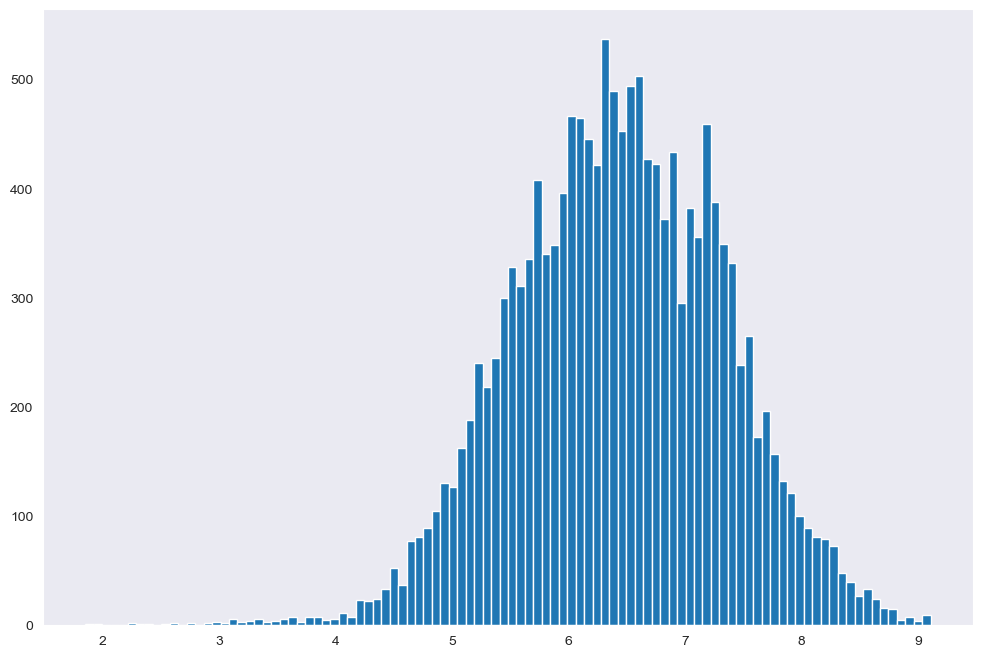

In [26]:
sns.set_style("dark")
plt.figure(figsize=(12,8))
plt.hist(data['mean'], bins=100)
plt.show()

In [27]:
fig = px.pie(data_main, 'media_type')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

*Notes:* Naturally TV has higher percentage as anime media.


<AxesSubplot: >

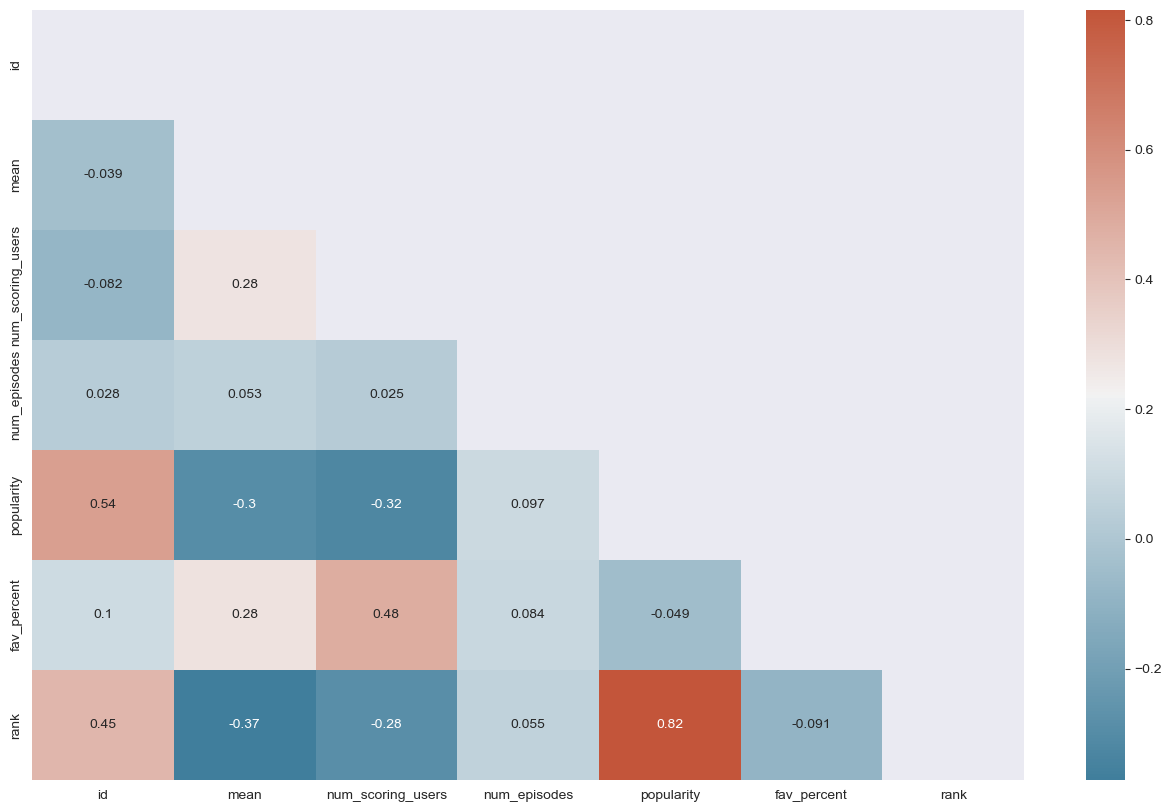

In [28]:
corr = data_main.corr()

# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(16, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

*Notes:*  So, basically interesting factors that are affecting the mean factor are : rank, popularity, num_scoring_users, ignore num_list_users for now till further investigation of difference.

In [29]:
fig = px.histogram(data[pd.to_datetime(data['start_date']).dt.year >= 1980], x='start_date', color='media_type')
fig.update_layout(bargap=0.1)

*Notes:* Obviously 2016 was a good year for Otakus :3 specially summer-Autumn-Fall seasons, with 119 tv, 45 movie, 23 ova, 61 ona, 60 special and 41 music. (Gotta check watching list lmao).

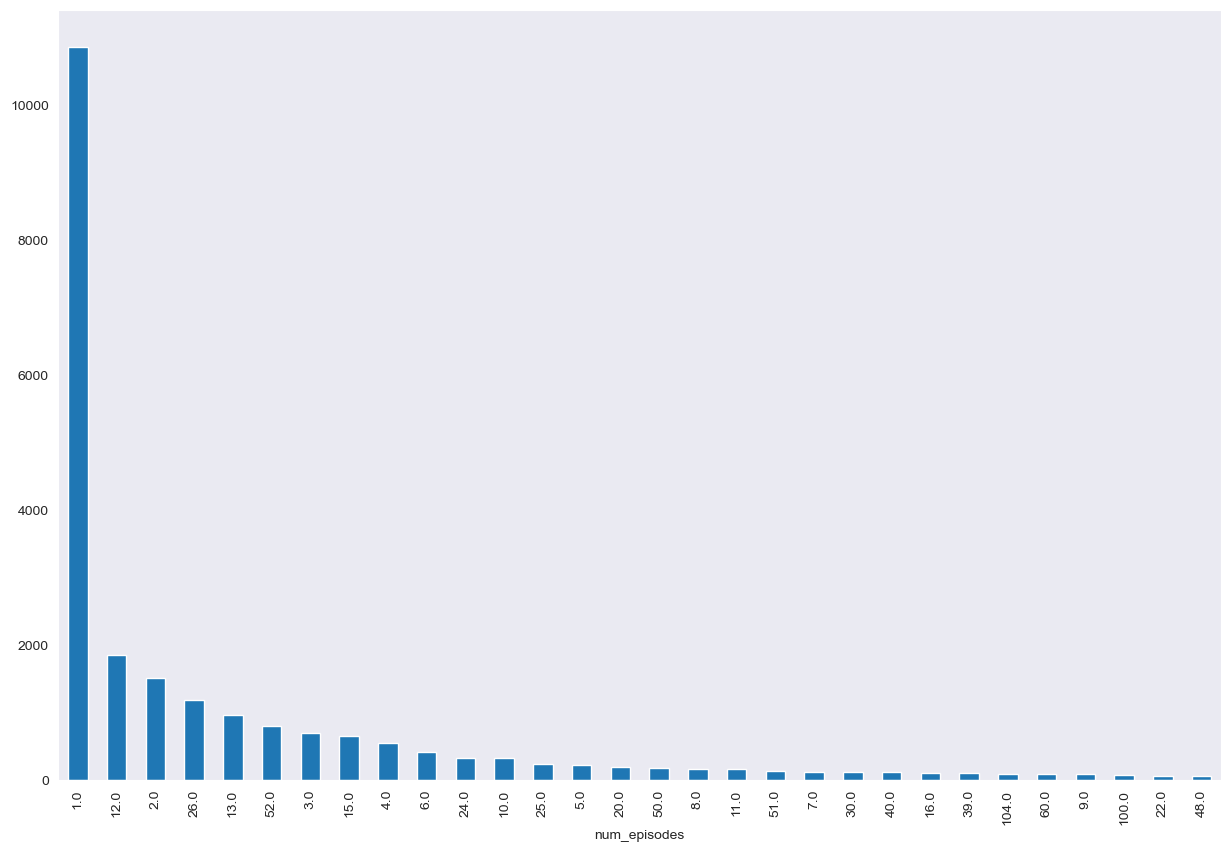

In [30]:
data_main.groupby('num_episodes')['id'].count().sort_values(ascending=False).head(30).plot(kind='bar', figsize=(15,10))
plt.show()

*Notes:* A lot of Movies (1 episode) that's why the spike, but the summation of all others are the other percentages of tv,ova,ona,... etc. most tv/specials are short 12 (episodes)/(season|title). </br>
*The fans of "When you have eliminated the impossible" teenager for 22+ years don't give up :(* </br>
*Gomu Gomu no guys don't be Sadge :(*

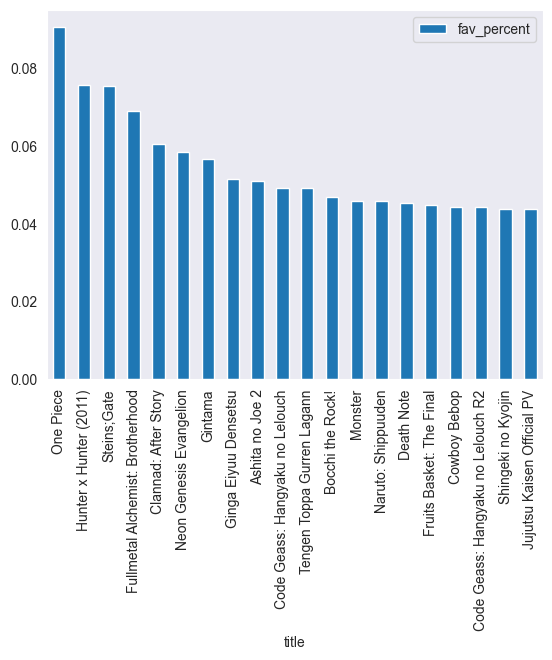

In [260]:
#data_main[['title','fav_percent']].sort_values(by=['fav_percent'],ascending=False).head(30).plot(kind='bar', figsize=(15,10))
data_main.sort_values(by=['fav_percent'],ascending=False)[1:21].plot(kind='bar',x='title',y='fav_percent');

One Piece in the top as expected

# 2- **MODELS TIME:** :3
![image info](https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/gettyimages-458406992-1538405221.jpg?crop=0.9xw:0.9xh;0,0&resize=256:*) <br />
  July's 2022 Work

## Similarity Analysis :

### Synopsis Keyword Analysis:
*(NLP)* :
* KeyBERT.
* Spacy.
* tqdm.
* CountVectorizer.
* TF-IDF

In [ ]:
import sweetviz as sv
#You could specify which variable in your dataset is the target for your model creation. We can specify it using the target_feat parameter.
data_report = sv.analyze(data_main)



In [ ]:
data_report.show_notebook(w=1500, h=900, scale=0.8)
data_report.show_html(scale=0.9)

### Cos-similarity:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet


In [ ]:
tfidf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['synopsis'] + data['genres'] + data['rating'] + data['studios']+data['media_type'])
tfidf_matrix.shape

Using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. 

$cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||}$

In [ ]:
cos_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
data = data_main.reset_index()
titles = data['title']
indices = pd.Series(data_main.index, index=data['title'])

In [ ]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cos_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    anime_indices = [i[0] for i in sim_scores]
    return titles.iloc[anime_indices]
data['title'][3]

In [ ]:
cos_results=get_recommendations('Death Note').head(10)
cos_results

Not so close recommendations but good start


#### **Featuring keywords and similarities:**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary='true')
#vectors=[None]*len(keywords)

In [ ]:
dfsyn['keywords'].head(4)

In [ ]:
dfsyn.head()

In [ ]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

# Apply clean_data function to your features.
features = ['genres', 'keywords', 'rating', 'media_type']

for feature in features:
    dfsyn[feature] = dfsyn[feature].apply(clean_data)

In [ ]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['genres']) + ' ' + x['rating'] + ' ' + ' '.join(x['media_type'])
dfsyn['soup'] = dfsyn.apply(create_soup, axis=1)

In [ ]:
dfsyn['soup'].head()

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cos_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cos_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    anime_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return dfsyn['title'].iloc[anime_indices]

In [ ]:


count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(dfsyn['soup'])



cos_sim2 = cosine_similarity(count_matrix, count_matrix)
dfsyn = dfsyn.reset_index()
indices = pd.Series(dfsyn.index, index=dfsyn['title'])

In [ ]:
cos2_results=get_recommendations('Death Note', cos_sim2)
len(cos2_results),cos2_results


**Cos-1 is genertated from similarity of multiple features using TF-IDF one of them was the whole synopsis of animes, while Cos2 was using keywords of synopsis instead of the whole synopsis feature**

In [ ]:
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten

import keras
from keras import layers 
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
rdf=pd.read_csv(r"../data-history/ratings-2020/rating_complete.csv")
n = 10

# Count the lines or use an upper bound
num_lines = sum(1 for l in open(r"../data-history/ratings-2020/rating_complete.csv"))

# The row indices to skip - make sure 0 is not included to keep the header!
skip_idx = [x for x in range(1, num_lines) if x % n != 0]

# Read the data
#rdf = pd.read_csv(r"../data-history/ratings-2020/rating_complete.csv", skiprows=skip_idx )
print(rdf.shape)
rdf.columns

### **Pair wise distance** :

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
# Removing Duplicated Rows
duplicates = rdf.duplicated()

if duplicates.sum() > 0:
    print('> {} duplicates'.format(duplicates.sum()))
    rdf = rdf[~duplicates]

print('> {} duplicates'.format(rdf.duplicated().sum()))

In [ ]:
rdf.columns

In [ ]:
# Scaling BTW (0 , 1.0)
min_rating = min(rdf['rating'])
max_rating = max(rdf['rating'])
rdf['rating'] = rdf["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

AvgRating = np.mean(rdf['rating'])
print('Avg', AvgRating)

In [ ]:
rdf.head(2)

In [ ]:
g = rdf.groupby('user_id')['rating'].count()
top_users = g.dropna().sort_values(ascending=False)[:20]
top_r = rdf.join(top_users, rsuffix='_r', how='inner', on='user_id')

g = rdf.groupby('id')['rating'].count()
top_animes = g.dropna().sort_values(ascending=False)[:20]
top_r = top_r.join(top_animes, rsuffix='_r', how='inner', on='id')

pd.crosstab(top_r.user_id, top_r.id, top_r.rating, aggfunc=np.sum)

In [ ]:
top_r.isnull().sum()

In [ ]:
anime_ids = rdf["id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
n_animes = len(anime2anime_encoded)
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}

rdf["anime"] = rdf["id"].map(anime2anime_encoded)

user_ids = rdf["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
n_users = len(user2user_encoded)
rdf["user"] = rdf["user_id"].map(user2user_encoded)


print("Num of users: {}, Num of animes: {}".format(n_users, n_animes))
print("Min rating: {}, Max rating: {}".format(min(rdf['rating']), max(rdf['rating'])))

In [ ]:
tmatrix = np.zeros((n_users, n_animes))
tmatrix.shape

In [ ]:
rdf.columns, rdf.shape

In [ ]:
for line in rdf.itertuples():
    tmatrix[line[5]-1, line[4]-1] = line[3]

In [ ]:
tmatrix[1]

In [ ]:
user_distances = pairwise_distances(tmatrix, metric="cosine")

# ".T" below is to transpose our 2D matrix.
tmatrix_transpose = tmatrix.T
anime_distances = pairwise_distances(tmatrix_transpose, metric="cosine")

user_distances.shape, anime_distances.shape

In [ ]:
user_similarity = 1 - user_distances
anime_similarity = 1 - anime_distances

In [ ]:
data_main.columns

In [ ]:
idx_to_anime = {}
for line in data_main.itertuples():
        idx_to_anime[(line[1])-1] = line[3]
anime_to_idx = {v: k for k, v in idx_to_anime.items()}

In [ ]:
anime_idx= anime_to_idx['Death Note']

def top_k_similar(similarity, mapper , anime_idx, k=8):
      return [mapper[x] for x in np.argsort(similarity[anime_idx,:])[:-k-2:-1]]

In [ ]:
pair_results= top_k_similar(anime_similarity,idx_to_anime ,anime_idx,k=8)
print(pair_results)

In [ ]:
def jaccard_similarity(a, b):
    # convert to set
    a = set(a)
    b = set(b)
    # calucate jaccard similarity
    j = float(len(a.intersection(b))) / len(a.union(b))
    return j
print('pair vs cos2')
print(jaccard_similarity(pair_results,cos2_results))
print('cos1 vs cos2')
print(jaccard_similarity(cos_results,cos2_results))

**zenzen wakaranaaaaaiiiii !!!!!!!!!!!!!** </br>
:"D </br>
pair-wise distance results not related to cosine Similarity results at all no intersections. </br>
using keywords or using Full synopsis didn't matter for cos similarity so better for resources use keywords

### **RecommendNet Maybe?** :

**Zenzen heiki janai :"D , Tasukete, Dare ka tasukeeteeeeee !** <br />
  Aug 2022 Work

In [ ]:
rdf.shape,rdf.isnull().sum(),len(rdf['user'])

In [ ]:
df.filter(regex='^media_type_',axis=1).head(2), df.filter(regex='^source_',axis=1).head(2)

In [ ]:
data['id'].values[1],data['popularity'].values[1]

#### *Normal Recommender features*

**Collaborative Filtering Approach, dependancy on user rates**

In [ ]:
# Shuffle
rdf = rdf.sample(frac=1, random_state=73)

X = rdf[['user', 'anime']].values
y = rdf["rating"]

In [ ]:
# Split
test_set_size = 10000 #10k for test set
train_indices = rdf.shape[0] - test_set_size 

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_test)))

In [ ]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
print(len(X_train))
print(len(y_train))

In [ ]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
print(len(X_train_array[0]))
print(len(X_test_array[0]))

In [ ]:
def recommender_net():
    embedding_size = 64
    
    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding',
                    input_dim = n_users, 
                    output_dim = embedding_size)(user)
    
    anime = Input(name = 'anime', shape = [1])
    anime_embedding = Embedding(name = 'anime_embedding',
                    input_dim = n_animes, 
                    output_dim = embedding_size)(anime)
    #x = Concatenate()([user_embedding, anime_embedding])
    x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])
    x = Flatten()(x)
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='adam')
    
    return model

model1 = recommender_net()
model1.summary()


In [ ]:
# Callbacks
from tensorflow.python.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

checkpoint_filepath = './weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                            save_weights_only=True,
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True)

early_stopping = EarlyStopping(patience = 3, monitor='val_loss', 
                            mode='min', restore_best_weights=True)

my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping,   
]

In [ ]:
print(len(X_test_array[0]))
print(len(y_test))


In [ ]:
# Model training
history = model1.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model1.load_weights(checkpoint_filepath)

In [ ]:
#Training results
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
from tqdm.keras import TqdmCallback


history = model1.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(X_test_array, y_test),
    verbose = 0, 
    callbacks=[TqdmCallback(verbose=0)])

model1.load_weights(checkpoint_filepath)



In [ ]:
#Training results
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

anime_weights = extract_weights('anime_embedding', model1)
user_weights = extract_weights('user_embedding', model1)

In [ ]:
data_main.columns

In [ ]:
name = data[data_main.id == 100].title.values[0]
print(name)

In [ ]:
# Fixing Names
def get_animename(anime_id):
    try:
        name = data[data_main.id == anime_id].title.values[0]
        return name
    except:
        print('error')
        return 0

data["eng_version"] = data['title']


data_main.sort_values(by=['mean'], 
                inplace=True,
                ascending=False, 
                kind='quicksort',
                na_position='last')

df = data[["id","title", "mean", "genres", "num_episodes", 
        "media_type","synopsis"]]


def get_animeframe(anime):
    if isinstance(anime, int):
        return df[df.id == anime]
    if isinstance(anime, str):
        return df[df.title == anime]
def get_sypnopsis(anime):
    if isinstance(anime, int):
        return df[df.id == anime].synopsis.values[0]

In [ ]:
df.shape

In [ ]:
pd.set_option("max_colwidth", None)

def find_similar_animes(name, n, return_dist=False, neg=False):
        index = get_animeframe(name).id.values[0]
        print(index)
        encoded_index = anime2anime_encoded.get(index)
        weights = anime_weights
        print(encoded_index)
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1            
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        print('animes closest to {}'.format(name))
        if return_dist:
            return dists, closest
        rindex = df
        similarityarr = []
        for close in closest:
            decoded_id = anime_encoded2anime.get(close)
            sypnopsis = get_sypnopsis(decoded_id)
            anime_frame = get_animeframe(decoded_id)
            anime_name = anime_frame.title.values[0]
            genre = anime_frame.genres.values[0]
            similarity = dists[close]
            similarityarr.append({"id": decoded_id, "title": anime_name,
                            "similarity": similarity,"genres": genre,
                            'synopsis': sypnopsis})
        frame = pd.Dataframe(similarityarr).sort_values(by="similarity", ascending=False)
        return frame[frame.id != index].drop(['id'], axis=1)


In [ ]:
find_similar_animes('Death Note', n=10, neg=False)

#### *Features modding* <br />
   Modifying parameters for Recommend NET

In [ ]:
# dfdl =pd.DataFrame()

In [ ]:
# dfdl_ids = data["id"].tolist()
# dfdlid_encoded = {x: i for i, x in enumerate(dfdl_ids)}
# n_animes = len(dfdlid_encoded)
# id_encoded2id = {i: x for i, x in enumerate(dfdl_ids)}
# dfdl["id"] = data["id"].map(dfdlid_encoded)

# dfdl_mean = data["mean"].tolist()
# dfdl_mean_encoded = {x: i for i, x in enumerate(dfdl_mean)}
# mean_encoded2mean = {i: x for i, x in enumerate(dfdl_mean)}
# n_users = len(dfdl_mean_encoded)
# dfdl["mean"] = data["mean"].map(dfdl_mean_encoded)

# dfdl_pop = data["popularity"].tolist()
# user2user_encoded = {x: i for i, x in enumerate(dfdl_pop)}
# user_encoded2user = {i: x for i, x in enumerate(dfdl_pop)}
# n_users = len(user2user_encoded)
# dfdl["popularity"] = data["popularity"].map(user2user_encoded)

In [ ]:
data_main.columns, data_main.shape

In [ ]:

# x1 = rdf[['user', 'anime']].values 

# #x2=  data[['id'],['popularity']].values
# x3=data[['mean'],['num_scoring_users']].values
# x4=data['rank'].tolist(),data['num_favorites'].tolist()
# x5= df.filter(regex='^media_type_',axis=1).values[i]
# x6= df.filter(regex='^source_',axis=1).values[i]

# y = rdf["rating"]
# # Split
# test_set_size = 250000 #10k for test set
# train_indices = rdf_sampled.shape[0] - test_set_size 
# len(x1),len(x2),len(x2[1]),len(x3),len(x3[1]),len(x4),len(x4[1]),len(y),


In [ ]:
# X3= x3[:,0] + x3[:,2] +x3[:,3] + x3[:,4] + x3[:,5] + x3[:,1] 
# X4=['None']*len(x4)*len(x4[1])
# for i in range(len(x4[1])):
#     X4 =X4 + x4[:,i]

In [ ]:
# X1_train, X1_test, y_train, y_test = (
#     x1[:train_indices],
#     x1[train_indices:],
#     y[:train_indices],
#     y[train_indices:],
# )

### *After Reading Some Articels:*

#### **Research at home** <br />
   Dec. 2022 work <br />

Semantic Similarity on synopsis using nlp models.

Potential Models for learning: <br />
* paraphrase-miniLM
* stsb-roberta latest alternatives
* bert-base-nli-mean-tokens

**To_Do:**
- Get embeddings from pretrained for all synopsis ( all paragraphs ).
- Compare Similarity using distance wise / cosine / pairwise whatever the hell will measure similarity of embeddings.
- Worst case senario ,(For each sentence embeddings in the requested anime synopsis loop cosine similarity between all sentences in all other synopsis)
- Optimization worth testing: Finding similarity between sentences in the same synopsis to get unique sentences and store those while ignoring sentences that are pretty much similar in embeddings, that leads to having smaller group of sentences for each synopsis to loop on (Still looping bratan).
- 5Head IDEA: Semantic Keyword embeddings similarity analysis to get potential chosen titles to do semantic sentence analysis on.
- **OR JUST USE PARAPHRASE MINING U Fokin IDIOT, anata BAKA ??? hontoni BAKAAAA.**